In [60]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import regularizers

In [61]:
# Set Environment Variables
%matplotlib inline
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [62]:
data_df = pd.read_csv('creditcard.csv')
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [63]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [64]:
neg, pos = np.bincount(data_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [65]:
data_df.isnull().values.any()

False

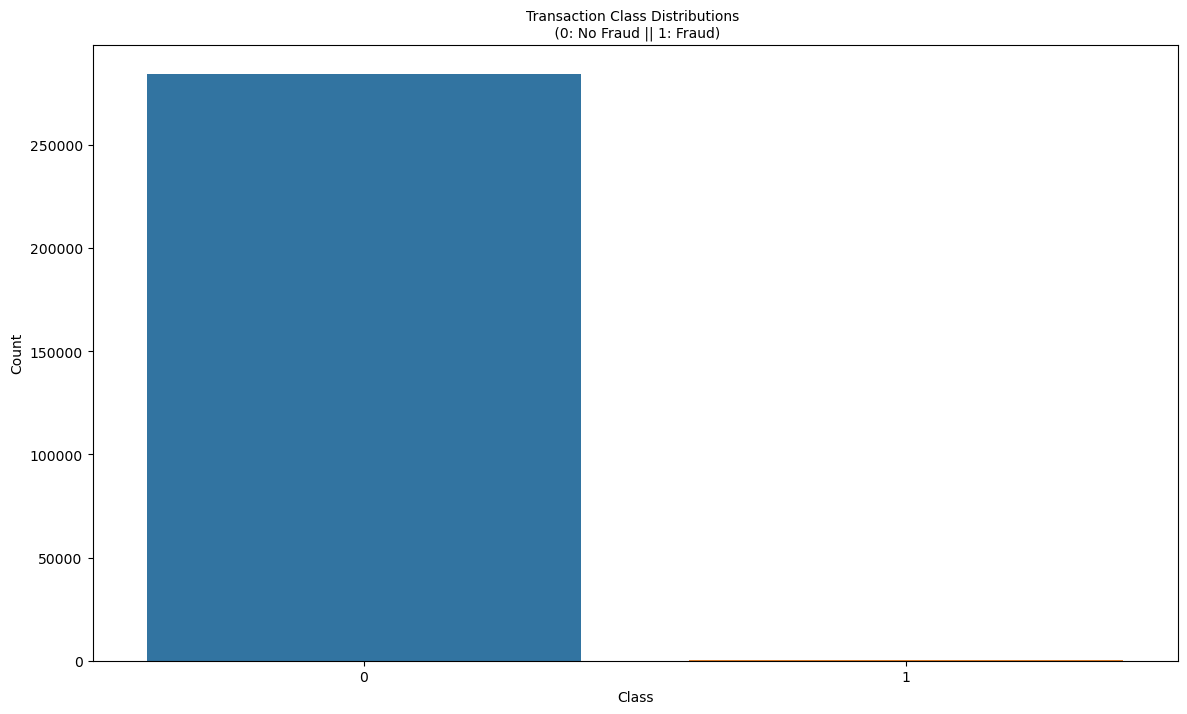

In [66]:
sns.countplot(x=data_df["Class"], data=data_df)
plt.title('Transaction Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=10)
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('BinmisMatches.png')

In [67]:
cleaned_data_df = data_df.copy()

# You don't want the `Time` column.
cleaned_data_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_data_df['Log Ammount'] = np.log(cleaned_data_df.pop('Amount')+eps)

In [68]:
cleaned_data_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log Ammount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


In [69]:
fraud = data_df[data_df['Class']==1]

normal = data_df[data_df['Class']==0]

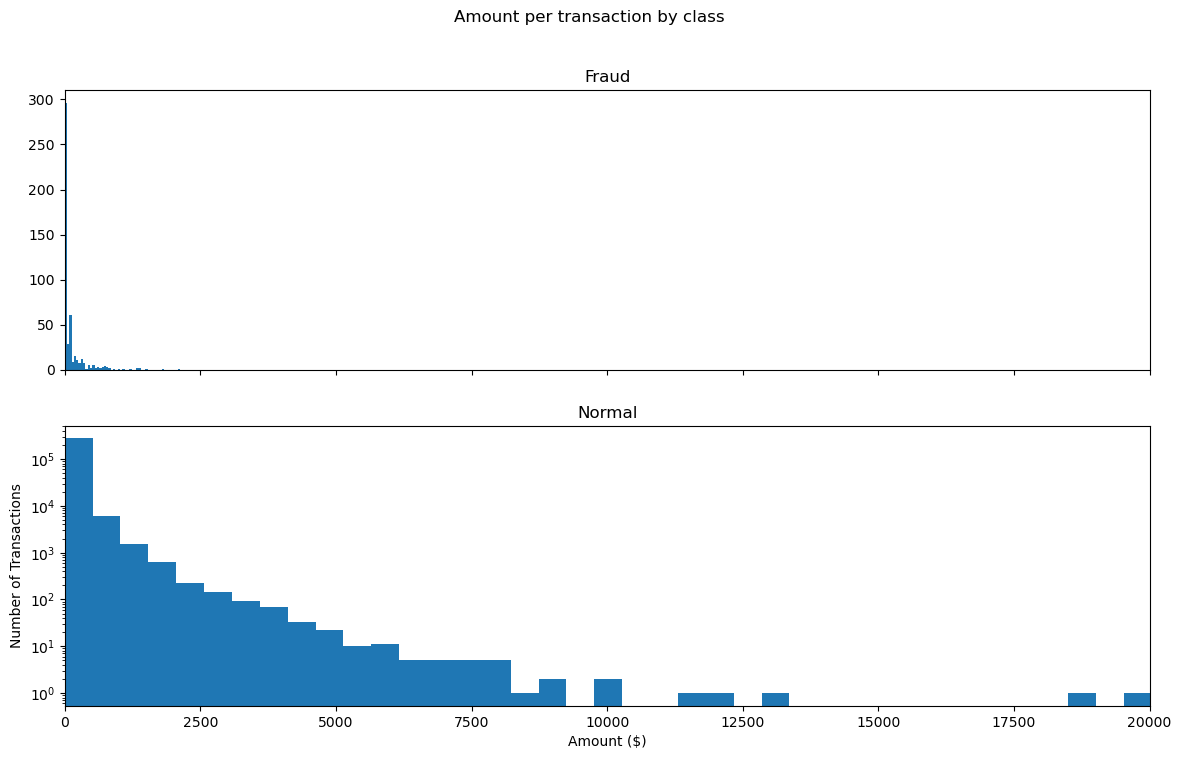

In [70]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

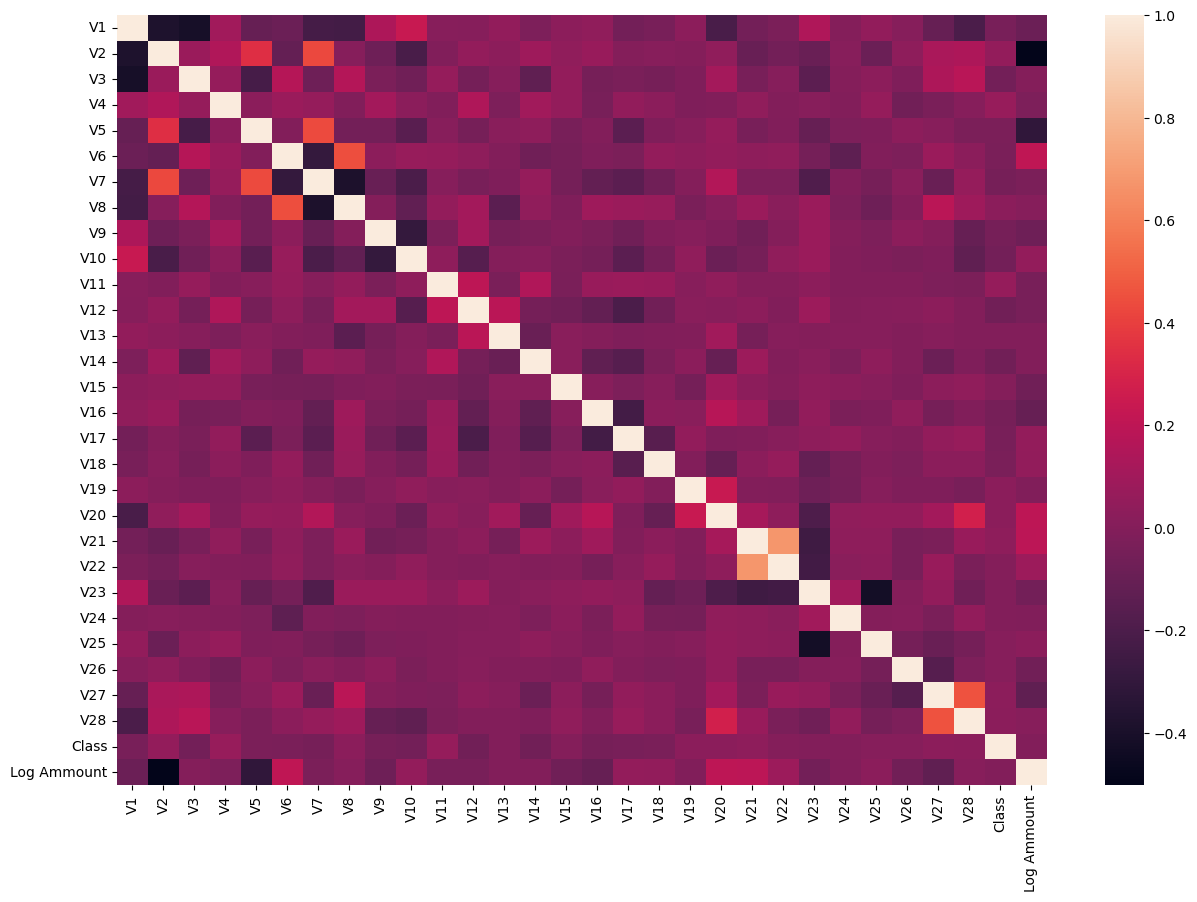

In [71]:
## Correlation
plt.figure(figsize=(15,10))
corr = cleaned_data_df.corr(method = 'spearman')
sns.heatmap(corr, annot = False)
plt.show()

In [72]:
#Determine the number of fraud and non-fraud transactions in the dataset
np.random.seed(11) 
non_fraud = cleaned_data_df[cleaned_data_df['Class'] == 0]
fraud = cleaned_data_df[cleaned_data_df['Class'] == 1]

In [73]:
outlier_fraction = len(fraud)/float(len(non_fraud))

In [74]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(fraud)))

print("Non_fraud Cases : {}".format(len(non_fraud)))

0.0017304750013189597
Fraud Cases : 492
Non_fraud Cases : 284315


In [75]:
cleaned_data_df.shape

(284807, 30)

In [76]:
df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

C:\Users\prami\AppData\Local\Temp\ipykernel_13092\4113564128.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)


In [77]:
print(X.shape)
print(Y.shape)

(284807, 29)
(284807,)


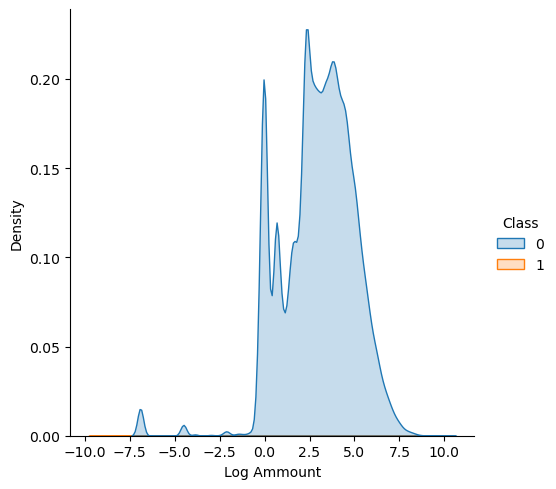

In [78]:
sns.displot(cleaned_data_df, x="Log Ammount", hue="Class", kind="kde", fill=True)

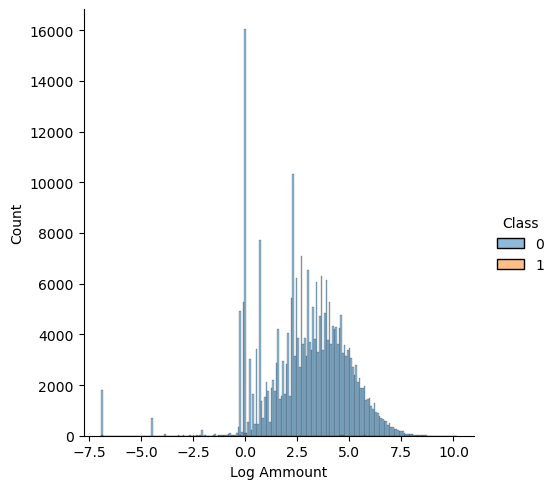

In [79]:
 sns.displot(cleaned_data_df, x="Log Ammount", hue="Class", )

In [80]:
# split data
X_train, X_test = train_test_split(cleaned_data_df, test_size=0.2, random_state=RANDOM_SEED)


In [81]:
# Train on Normal (Class=0)
X_train = X_train[X_train.Class == 0]

In [82]:
# "Class" variable is not needed
X_train = X_train.drop(['Class'], axis=1)
# test data
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)


In [83]:
# Standardize data based on mean & sd of X_train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [84]:
# convert to numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [85]:
# check standardization of the data
print(np.mean(X_train,axis=0))
print(np.std(X_train,axis=0))
print(np.mean(X_test,axis=0))
print(np.std(X_test,axis=0))

[ 1.03214899e-16  1.43232540e-17 -7.22879165e-17  8.57208483e-17
 -7.77235680e-17 -2.73656936e-17  7.15225518e-17  2.63660335e-17
  2.81154386e-19 -1.07213539e-16 -7.26627891e-17 -1.07151060e-16
  3.14268125e-17  1.33485855e-16  1.74003325e-17 -1.26332037e-16
 -3.11956411e-16  1.17928645e-17 -1.45263099e-17 -1.11680770e-17
  2.18675633e-18 -9.80916413e-18  5.04828320e-17 -3.21140787e-17
 -2.20549996e-17 -3.33011750e-17 -2.06179883e-18 -1.92434557e-17
  9.70045110e-15]
[0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978 0.9999978
 0.9999978]
[-0.00639046  0.00490787 -0.00499871  0.01085818 -0.00744952  0.00043301
 -0.01247928  0.00270441 -0.00849447 -0.0033515   0.00373365 -0.00417644
 -0.00041475 -0.01365107 -0.00030812 -0.01247874 -0.01955771 -0.00262847
  0.00078902

In [86]:
#set up for VAE
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import regularizers

In [87]:
# defining the key parameters
batch_size = 100
original_dim = 29
latent_dim = 5
intermediate_dim1 = 20
intermediate_dim2 = 10
epochs = 50
epsilon_std = 1.0

In [88]:
# sampling from mean and sd in VAE
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [89]:
# input to our encoder

x = Input(shape=(original_dim,), name="input")
# intermediate layer
#h1 = Dense(intermediate_dim1, activation='tanh', name="encoding1")(x)
h1 = Dense(intermediate_dim1, activation="tanh", name="encoding1", activity_regularizer=regularizers.l1(10e-5))(x)
h = Dense(intermediate_dim2, activation='relu', name="encoding")(h1)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 29)]         0           []                               
                                                                                                  
 encoding1 (Dense)              (None, 20)           600         ['input[0][0]']                  
                                                                                                  
 encoding (Dense)               (None, 10)           210         ['encoding1[0][0]']              
                                                                                                  
 mean (Dense)                   (None, 5)            55          ['encoding[0][0]']               
                                                                                            

In [90]:
# Input to the decoder

input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h1 = Dense(intermediate_dim2, activation='relu', name="decoder_h2")(input_decoder)
decoder_h = Dense(intermediate_dim1, activation='relu', name="decoder_h")(decoder_h1)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='tanh', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 5)]               0         
                                                                 
 decoder_h2 (Dense)          (None, 10)                60        
                                                                 
 decoder_h (Dense)           (None, 20)                220       
                                                                 
 flat_decoded (Dense)        (None, 29)                609       
                                                                 
Total params: 889
Trainable params: 889
Non-trainable params: 0
_________________________________________________________________


In [91]:
# variational Autoencoder

# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 29)]              0         
                                                                 
 encoder (Functional)        [(None, 5),               920       
                              (None, 5),                         
                              (None, 5)]                         
                                                                 
 decoder (Functional)        (None, 29)                889       
                                                                 
Total params: 1,809
Trainable params: 1,809
Non-trainable params: 0
_________________________________________________________________


In [92]:
# Defination VAE Loss Function
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

In [93]:
vae.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [94]:
history = vae.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

Epoch 1/50
2275/2275 [==============================] - 3s 1ms/step - loss: 0.7808 - accuracy: 0.2177 - val_loss: 0.7283 - val_accuracy: 0.2814
Epoch 2/50
2275/2275 [==============================] - 3s 1ms/step - loss: 0.6680 - accuracy: 0.3191 - val_loss: 0.6870 - val_accuracy: 0.3473
Epoch 3/50
2275/2275 [==============================] - 3s 1ms/step - loss: 0.6431 - accuracy: 0.3426 - val_loss: 0.6728 - val_accuracy: 0.3458
Epoch 4/50
2275/2275 [==============================] - 3s 1ms/step - loss: 0.6332 - accuracy: 0.3407 - val_loss: 0.6658 - val_accuracy: 0.3455
Epoch 5/50
2275/2275 [==============================] - 3s 1ms/step - loss: 0.6266 - accuracy: 0.3372 - val_loss: 0.6595 - val_accuracy: 0.3361
Epoch 6/50
2275/2275 [==============================] - 3s 1ms/step - loss: 0.6213 - accuracy: 0.3315 - val_loss: 0.6546 - val_accuracy: 0.3326
Epoch 7/50
2275/2275 [==============================] - 3s 1ms/step - loss: 0.6169 - accuracy: 0.3285 - val_loss: 0.6511 - val_accuracy:

In [95]:
# prediction & reconstruction error

predictions = vae.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
print("Full Sample",error_df.describe())
error_df_true = error_df[(error_df['true_class']== 0)]
print("Normal Sample",error_df_true.describe())
error_df_false = error_df[(error_df['true_class']== 1)]
print("Fraud Sample",error_df_false.describe())

1781/1781 [==============================] - 1s 598us/step
Full Sample        reconstruction_error    true_class
count          56962.000000  56962.000000
mean               0.589436      0.001720
std                3.226592      0.041443
min                0.010869      0.000000
25%                0.128053      0.000000
50%                0.240916      0.000000
75%                0.467993      0.000000
max              223.578008      1.000000
Normal Sample        reconstruction_error  true_class
count          56864.000000     56864.0
mean               0.545075         0.0
std                2.651294         0.0
min                0.010869         0.0
25%                0.127942         0.0
50%                0.240385         0.0
75%                0.466123         0.0
max              223.578008         0.0
Fraud Sample        reconstruction_error  true_class
count             98.000000        98.0
mean              26.329637         1.0
std               36.363248         0.0
min 

In [96]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

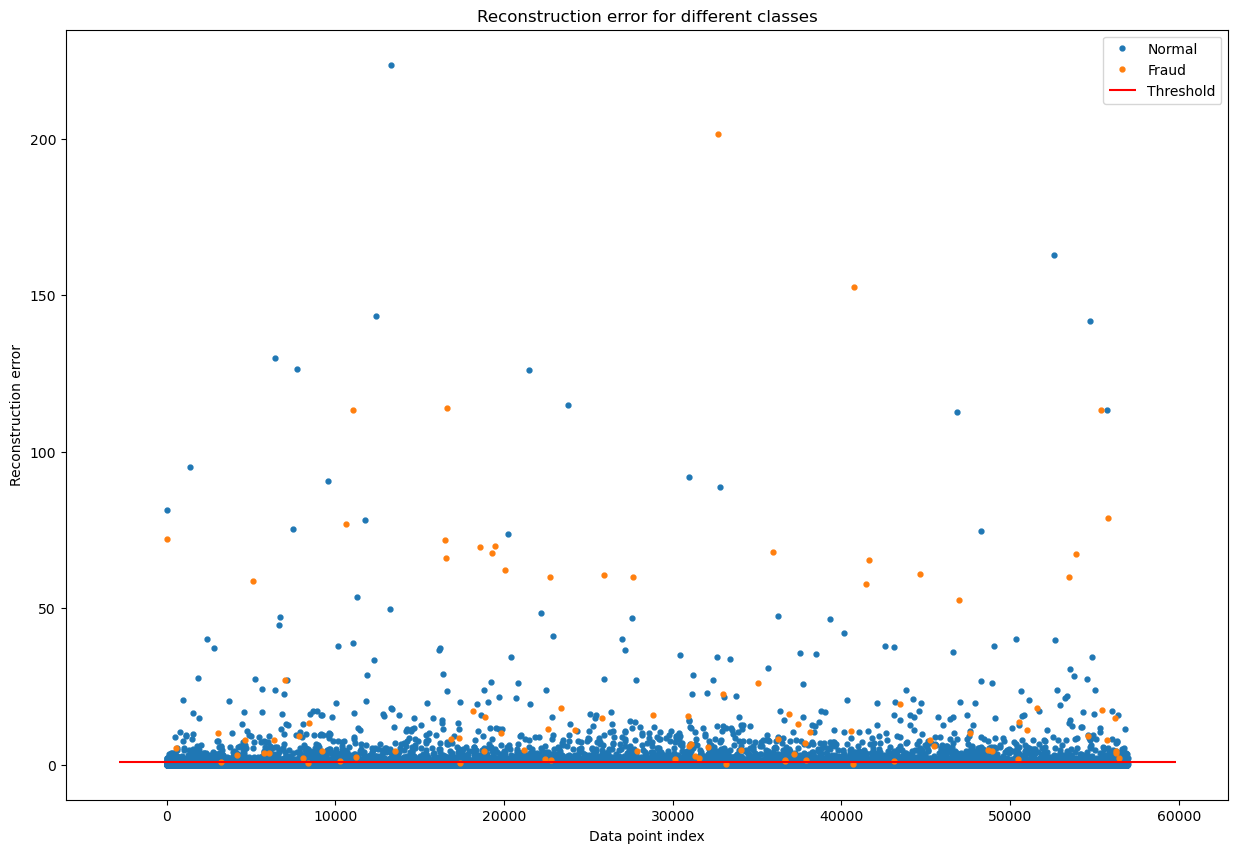

In [97]:
# scatter plot
threshold = 0.9
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(15, 10))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

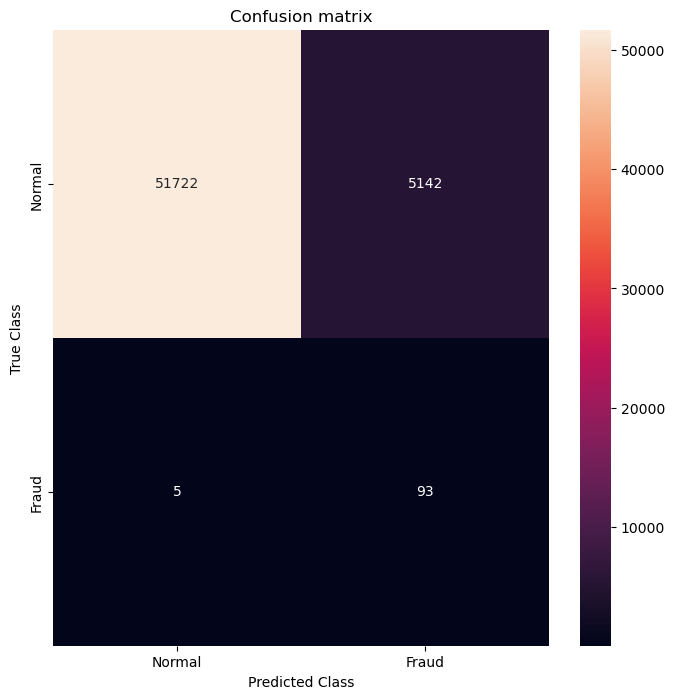

In [98]:
# confusion matrix
threshold = 0.9
# And see how well we're dividing the two types of transactions:
groups = error_df.groupby('true_class')
# predict fraud
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

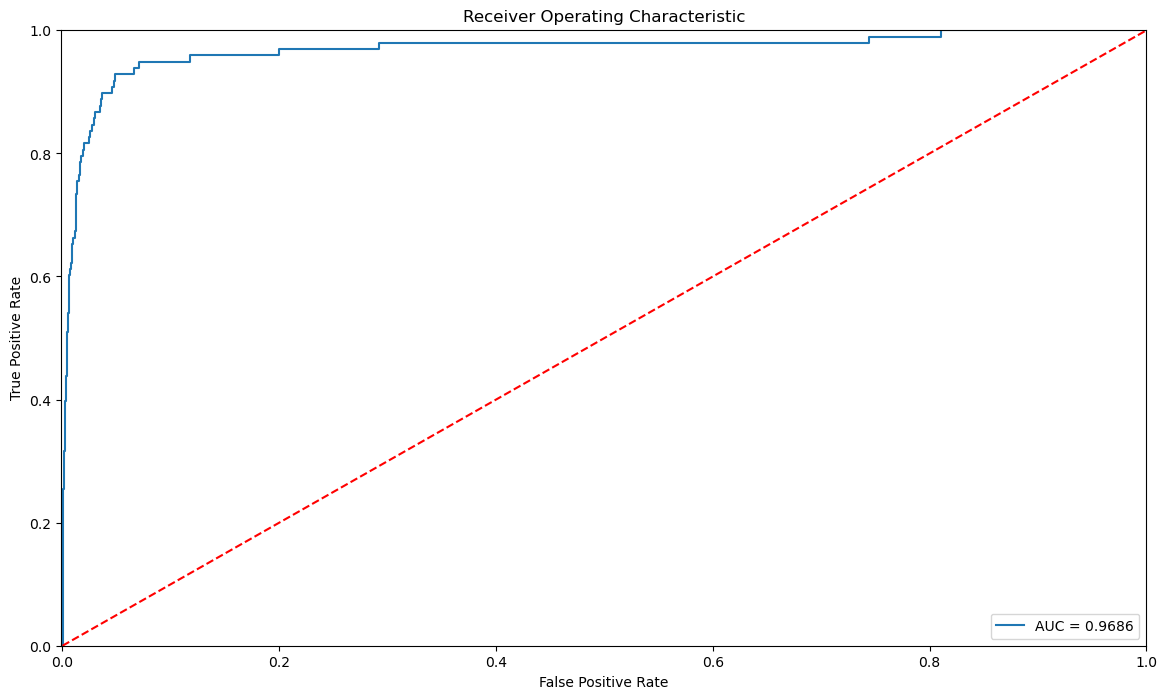

In [99]:
# ROC
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();


In [100]:
#k-means
from sklearn.cluster import KMeans
from time import time
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [101]:
df_kmeans=pd.read_csv('creditcard.csv')
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log Ammount
0,1.114581,0.224734,0.485133,1.135030,-0.205889,-0.203324,-0.036011,0.072799,-0.282224,0.187626,...,0.168254,0.508101,-0.075061,0.226639,0.537610,-0.281658,0.029001,0.012025,0,2.637699
1,-0.222768,0.603093,1.151091,-0.277716,-0.198779,-0.391376,0.554619,-0.087446,0.447401,-0.668931,...,-0.022894,0.057405,0.160402,-0.037584,-1.175218,-0.691534,0.170161,0.226304,0,3.911843
2,1.914967,-0.586340,-0.595441,0.212036,-0.299135,0.474608,-0.763305,0.239555,1.258168,-0.017347,...,0.228882,0.781483,0.072629,0.239794,-0.079634,-0.235412,0.029141,-0.040531,0,3.582713
3,-0.426143,1.340168,0.751184,0.492432,0.607224,-0.906310,0.884231,-0.075119,-1.159509,-0.860644,...,-0.015515,-0.057587,-0.303485,0.219998,0.059505,0.430679,0.062164,0.122413,0,-0.273122
4,-0.923973,-0.753696,0.801803,0.745919,2.109769,0.325201,0.626670,-0.390511,0.979546,0.600218,...,-0.378782,-0.342673,0.146229,0.025100,-0.611605,-0.979592,-0.582397,-0.169350,0,1.946053


In [102]:
X_kmean = df.iloc[:,:-1]
y_kmean = df['Class']
#print(X_kmean)

In [103]:
X_scaled=scale(X_kmean)
print(X_scaled)

[[ 0.56904318  0.13609468  0.31995555 ...  0.07185104  0.03642949
  -0.04159898]
 [-0.11373305  0.365222    0.7591682  ...  0.42157602  0.68559682
  -0.04159898]
 [ 0.97767626 -0.3550766  -0.3927055  ...  0.07219658 -0.12278981
  -0.04159898]
 ...
 [-1.03305102  0.8940668   1.07029585 ... -0.86405716  0.07679328
  -0.04159898]
 [ 1.08400067 -0.70474911  0.02393857 ...  0.00879813 -0.12002428
  -0.04159898]
 [-0.32270059  0.98645697 -0.07193225 ...  1.44261465  0.91003119
  -0.04159898]]


In [104]:
pca=PCA(n_components=2)
print(pca)

PCA(n_components=2)


In [105]:
X_reduced=pca.fit_transform(X_scaled)
print(X_reduced)

[[-0.08669357  0.29667465]
 [-0.09053176 -0.07006983]
 [-0.08804861 -0.18174614]
 ...
 [-0.15770951  0.20657778]
 [-0.09222028 -0.00988505]
 [ 0.01261403 -0.46183351]]


In [106]:
X_train_k,X_test_k,y_train_k,y_test_k=train_test_split(X_reduced,y_kmean,test_size=0.33,random_state=500)

In [107]:
kmeans=KMeans(init='k-means++',n_clusters=2,n_init=10)
kmeans.fit(X_train_k)

KMeans(n_clusters=2)

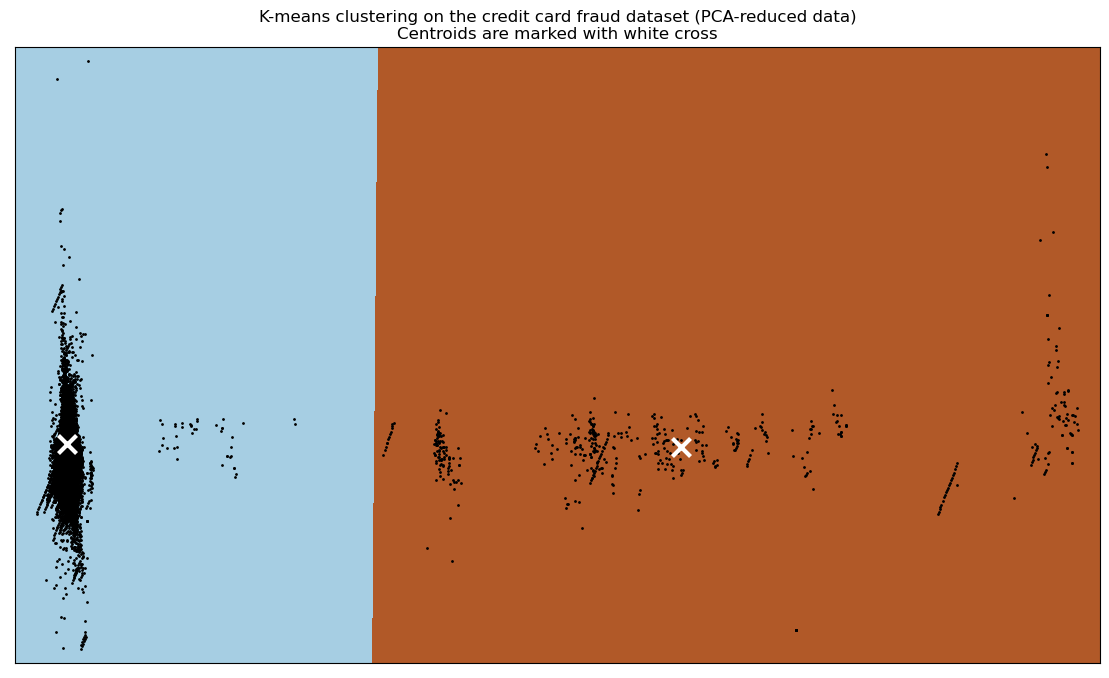

In [108]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(X_reduced[:, 0], X_reduced[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the credit card fraud dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [109]:
predictions = kmeans.predict(X_test_k)


In [110]:
predictions.shape

(93987,)

In [111]:
pred_fraud = np.where(predictions == 1)[0]
real_fraud = np.where(y_test == 1)[0]
false_pos = len(np.setdiff1d(pred_fraud, real_fraud))

pred_good = np.where(predictions == 0)[0]
real_good = np.where(y_test == 0)[0]
false_neg = len(np.setdiff1d(pred_good, real_good))

false_neg_rate = false_neg/(false_pos+false_neg)

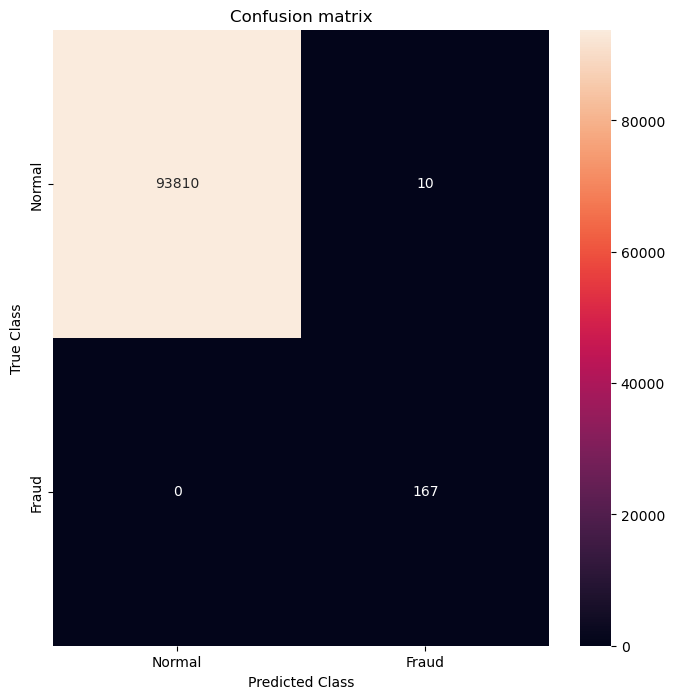

In [112]:
# confusion matrix
threshold = 0.9
conf_matrix_kmeans = confusion_matrix(y_test_k, predictions)
# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_kmeans, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

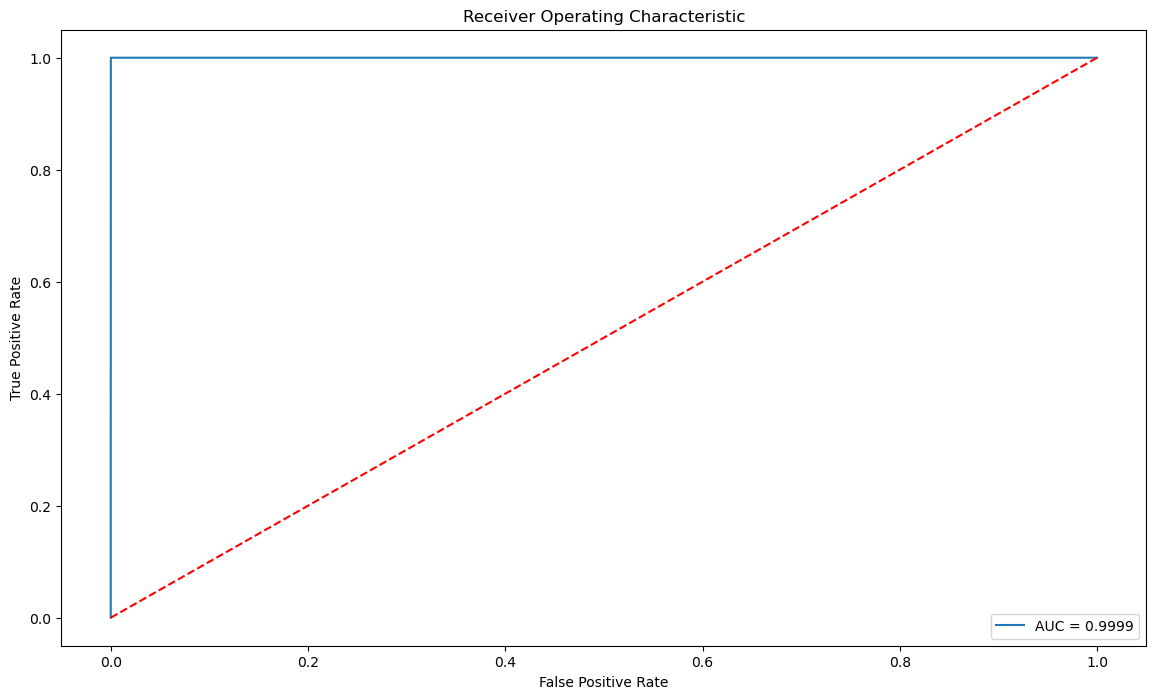

In [113]:
# ROC
fpr, tpr, thresholds = roc_curve(y_test_k, predictions)
roc_auc = auc(fpr, tpr)
# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
#plt.xlim([-0.001, 1])
#plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [114]:
ns_probs = [0 for _ in range(len(y_test_k))]

In [115]:
from sklearn.metrics import roc_auc_score
ns_auc = roc_auc_score(y_test_k, ns_probs)
km_auc = roc_auc_score(y_test_k, predictions)

In [116]:
print('ROC AUC=%.4f' % (ns_auc))
print('ROC AUC=%.4f' % (km_auc))

ROC AUC=0.5000
ROC AUC=0.9999


In [119]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [120]:
data1= data_df.sample(frac = 0.1,random_state=1)

data1.shape

(28481, 31)

In [121]:
data_df.shape

(284807, 31)

In [122]:
#Create independent and Dependent Features
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


In [123]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [124]:
type(classifiers)

dict

C:\Users\prami\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


<class 'sklearn.ensemble._iforest.IsolationForest'>: 73
0.9974368877497279


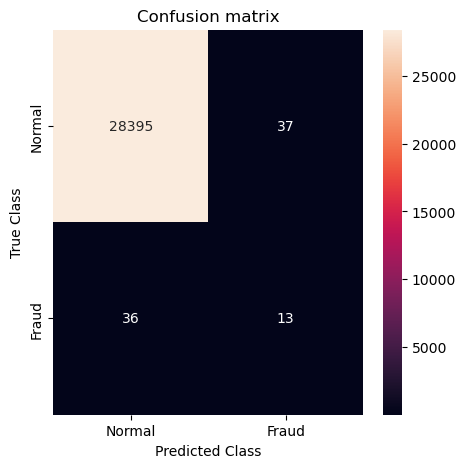

In [125]:
clf_name1 = IsolationForest
clf1 = IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction, verbose=0)
clf1.fit(X)
scores_prediction = clf1.decision_function(X)
y_pred = clf1.predict(X)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != Y).sum()
print("{}: {}".format(clf_name1,n_errors))
print(accuracy_score(Y,y_pred))    
conf_matrix_lk1 = confusion_matrix(Y,y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix_lk1, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()
    

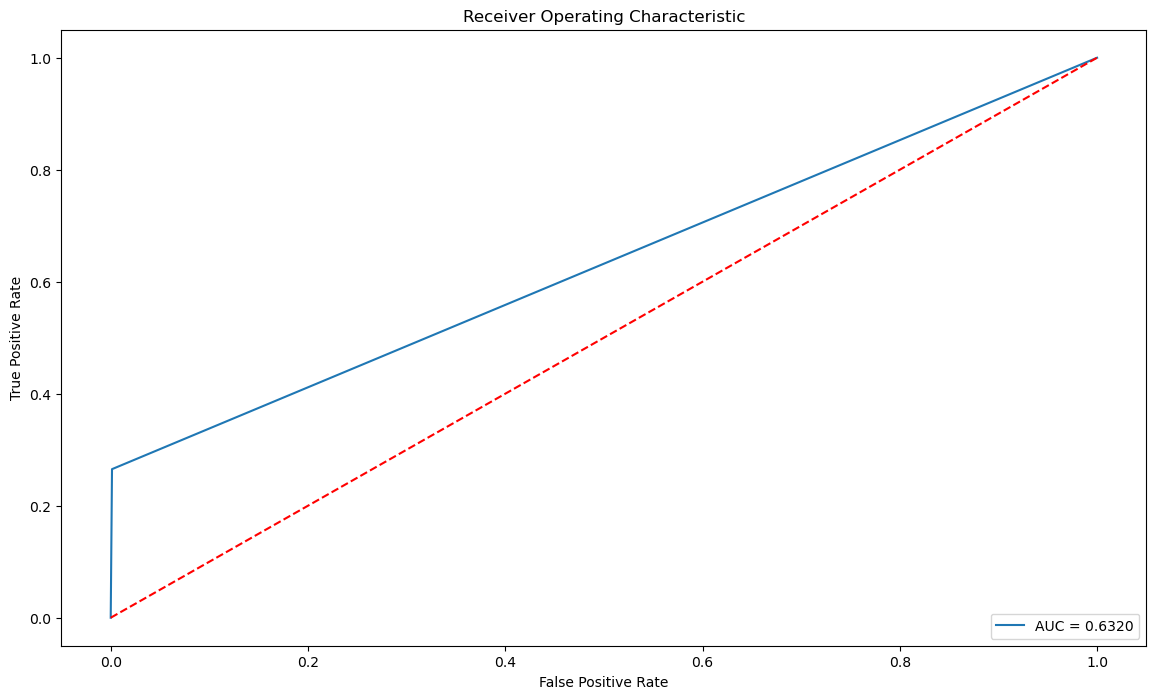

In [126]:
# ROC
fpr, tpr, thresholds = roc_curve(Y,y_pred)
roc_auc = auc(fpr, tpr)
# plot
#plot_roc_curve(clf1, X_train, y_train, X_test, y_test)
# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
#plt.xlim([-0.001, 1])
#plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

<class 'sklearn.neighbors._lof.LocalOutlierFactor'>: 97
0.9965942207085425


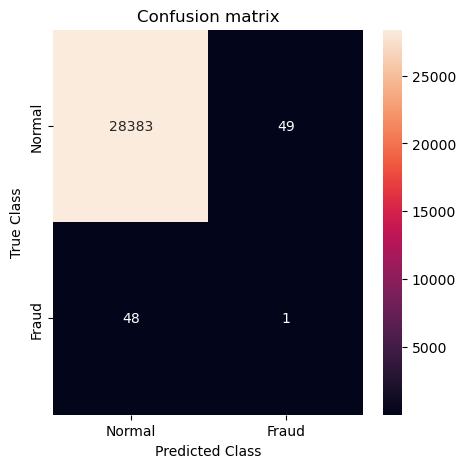

In [127]:
clf_name2 = LocalOutlierFactor
clf2 = LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction)
clf2.fit(X)
#scores_prediction = clf2.decision_function(X)

y_pred = clf2.fit_predict(X)
scores_prediction = clf2.negative_outlier_factor_
#y_pred = clf2.predict(X)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != Y).sum()
print("{}: {}".format(clf_name2,n_errors))
print(accuracy_score(Y,y_pred))    
conf_matrix_lk2 = confusion_matrix(Y,y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix_lk2, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

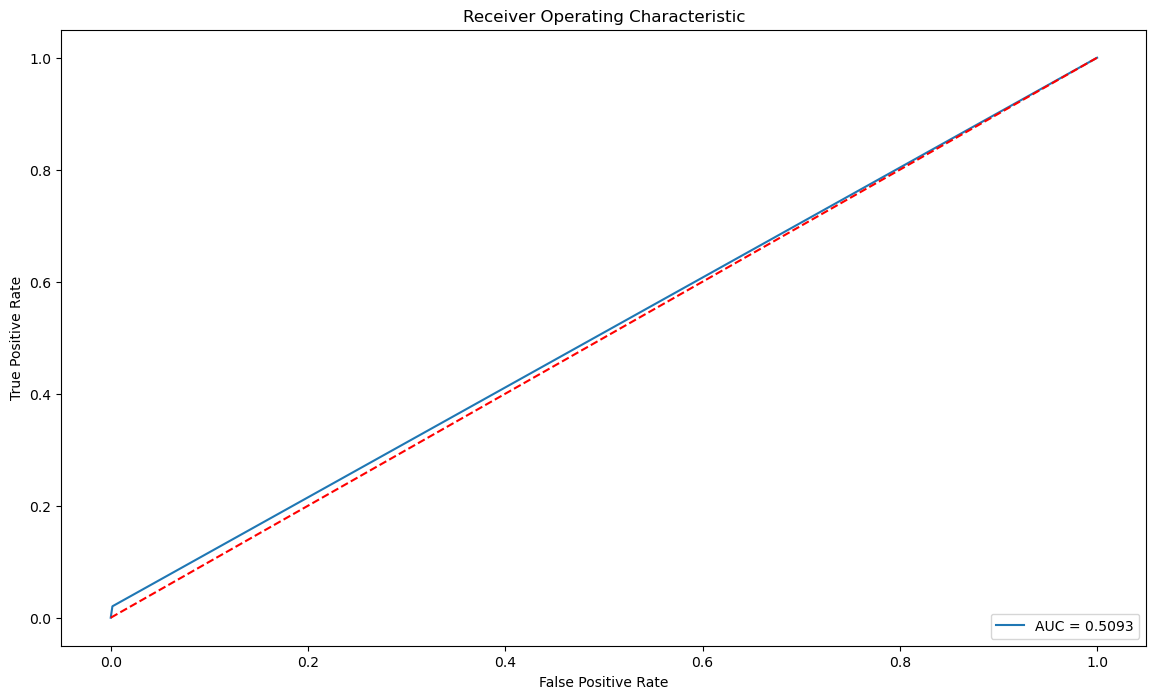

In [128]:
# ROC
fpr, tpr, thresholds = roc_curve(Y,y_pred)
roc_auc = auc(fpr, tpr)
# plot
#plot_roc_curve(clf1, X_train, y_train, X_test, y_test)
# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
#plt.xlim([-0.001, 1])
#plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

<class 'sklearn.svm._classes.OneClassSVM'>: 8516
0.7009936448860644


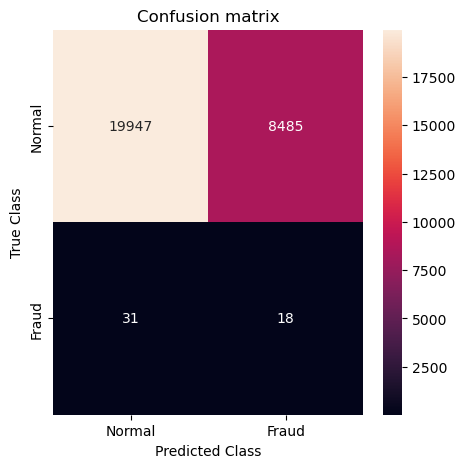

In [129]:
clf_name3 = OneClassSVM
clf3 = OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
clf3.fit(X)
#scores_prediction = clf2.decision_function(X)

y_pred = clf3.fit_predict(X)
#scores_prediction = clf3.negative_outlier_factor_
#y_pred = clf2.predict(X)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != Y).sum()
print("{}: {}".format(clf_name3,n_errors))
print(accuracy_score(Y,y_pred))    
conf_matrix_lk3 = confusion_matrix(Y,y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix_lk3, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

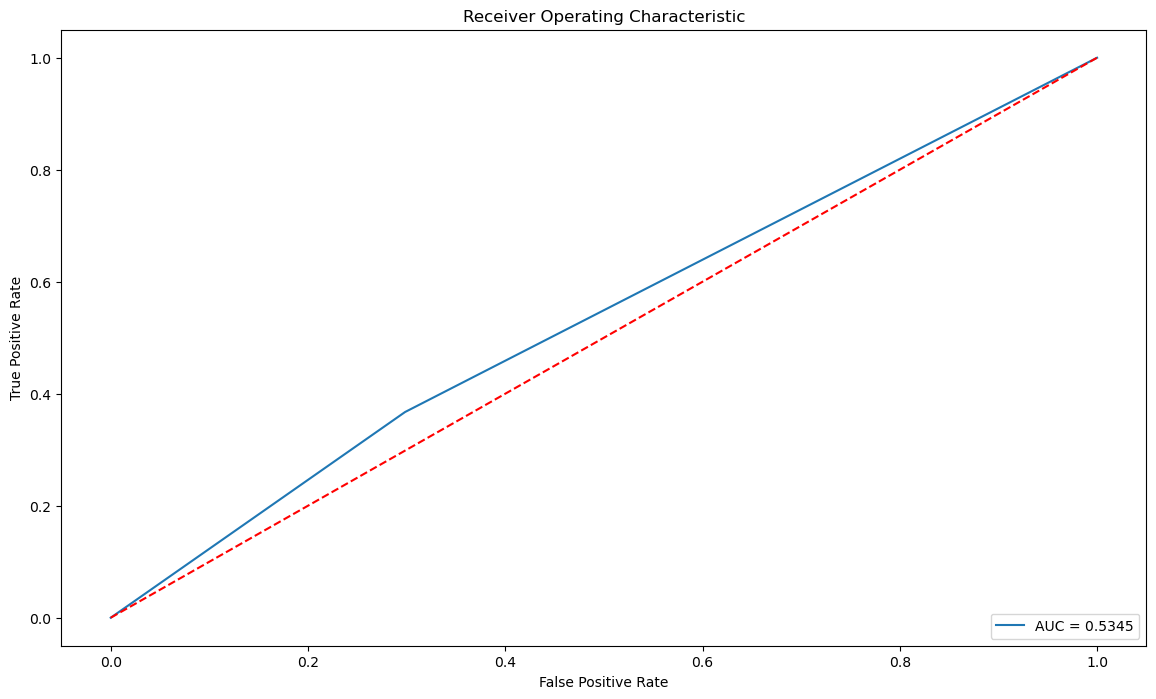

In [130]:
# ROC
fpr, tpr, thresholds = roc_curve(Y,y_pred)
roc_auc = auc(fpr, tpr)
# plot
#plot_roc_curve(clf1, X_train, y_train, X_test, y_test)
# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
#plt.xlim([-0.001, 1])
#plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

C:\Users\prami\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 77
0.9972964432428637


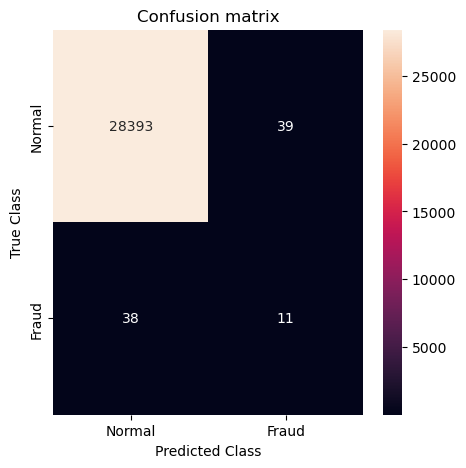

Local Outlier Factor: 97
0.9965942207085425


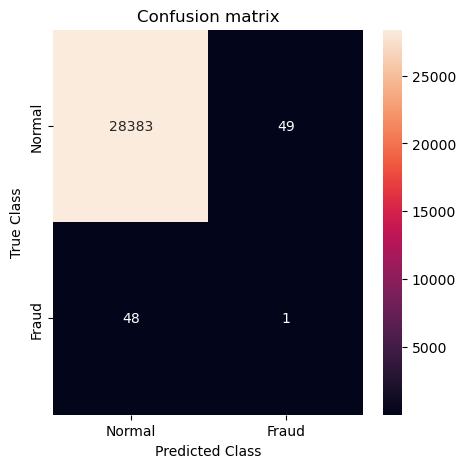

Support Vector Machine: 8516
0.7009936448860644


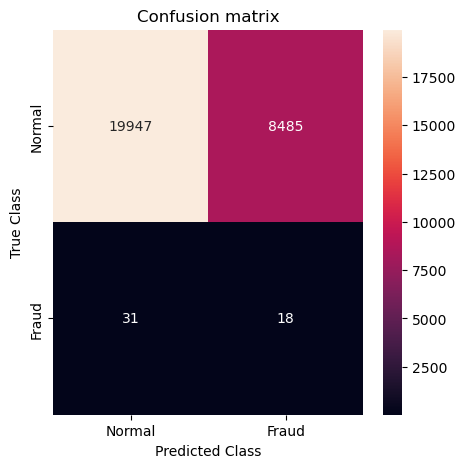

In [78]:
n_outliers = len(fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
        #
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    #print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    #print("Classification Report :")
    #print(classification_report(Y,y_pred))
    conf_matrix_lk = confusion_matrix(Y,y_pred)
    # plot confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix_lk, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()
    